In [ ]:
# Зашумить изображение при помощи шума гаусса, постоянного шума.
# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# Выяснить, какой фильтр показал лучший результат фильтрации шума.

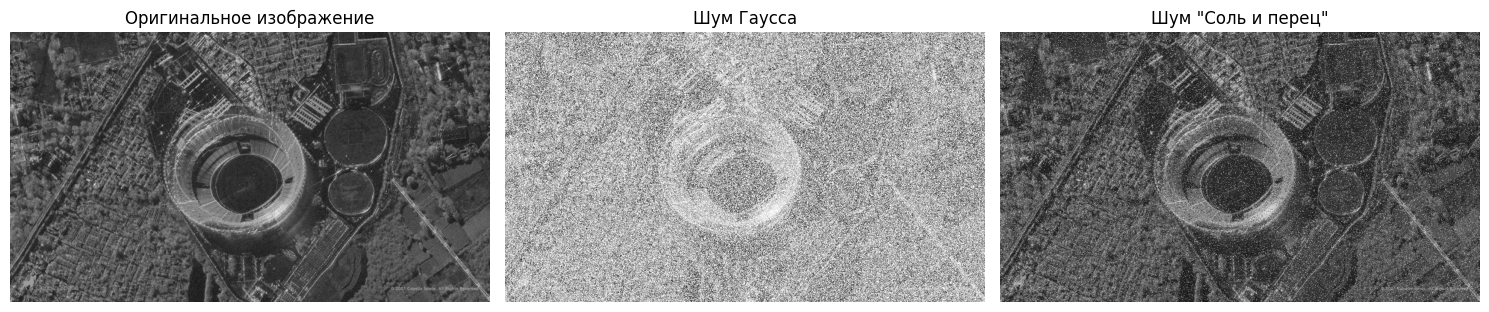

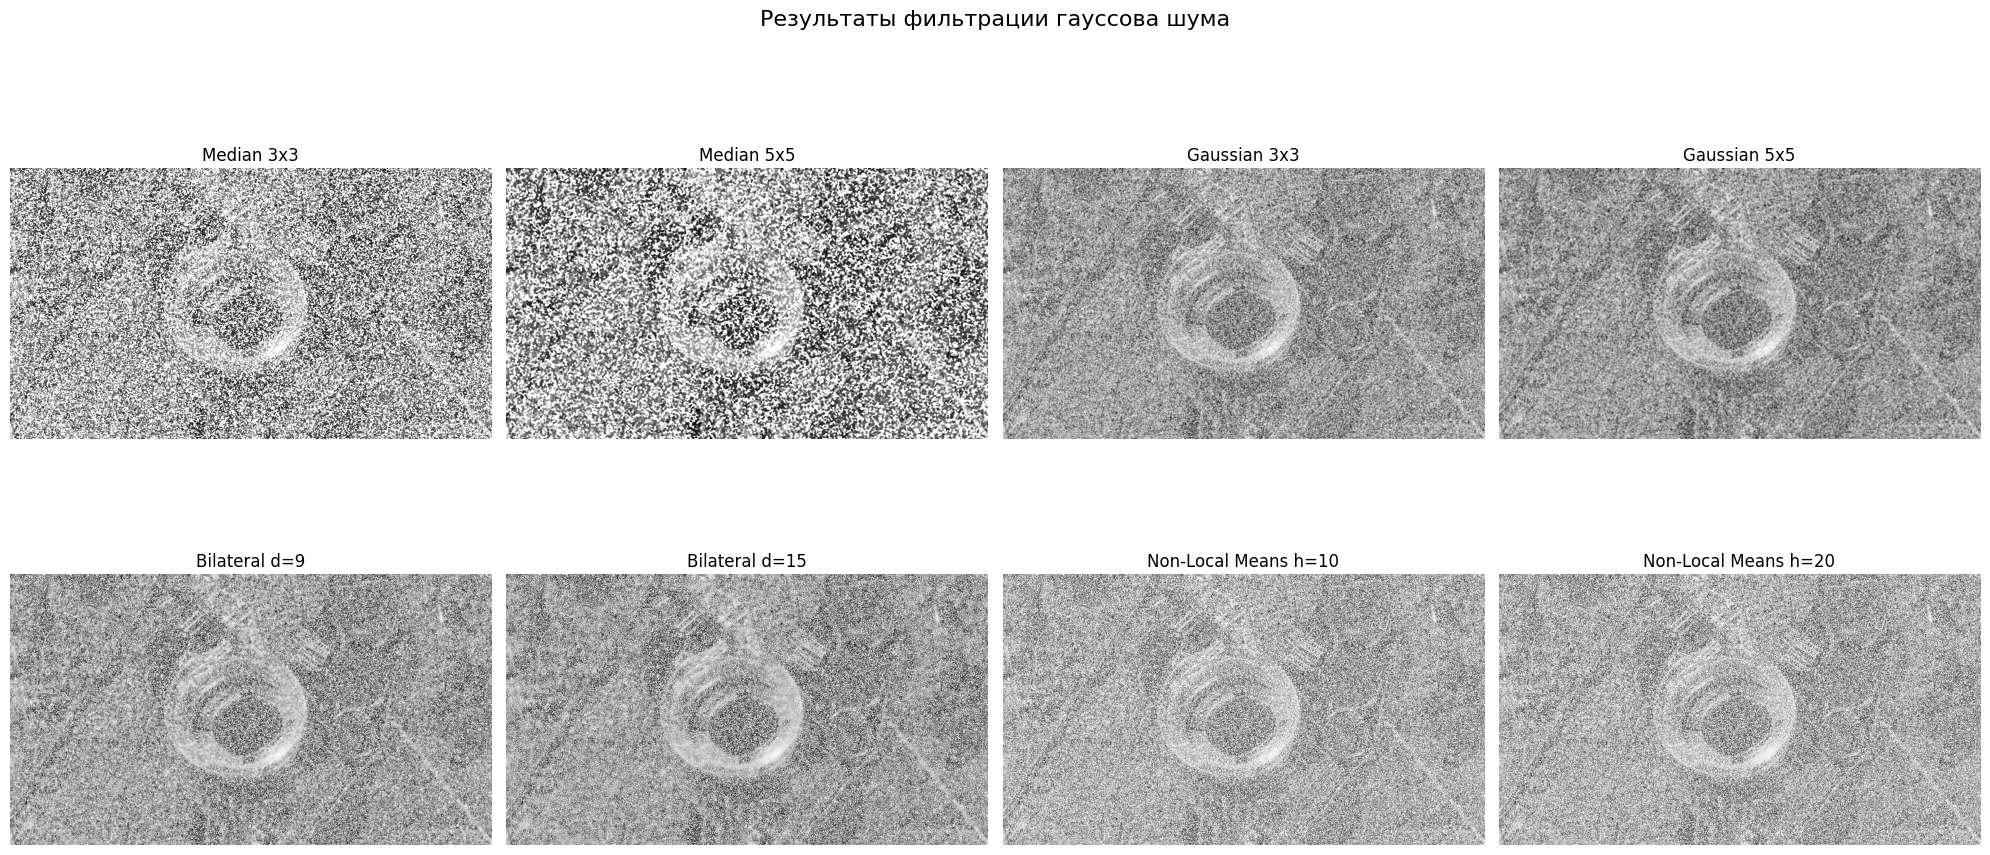

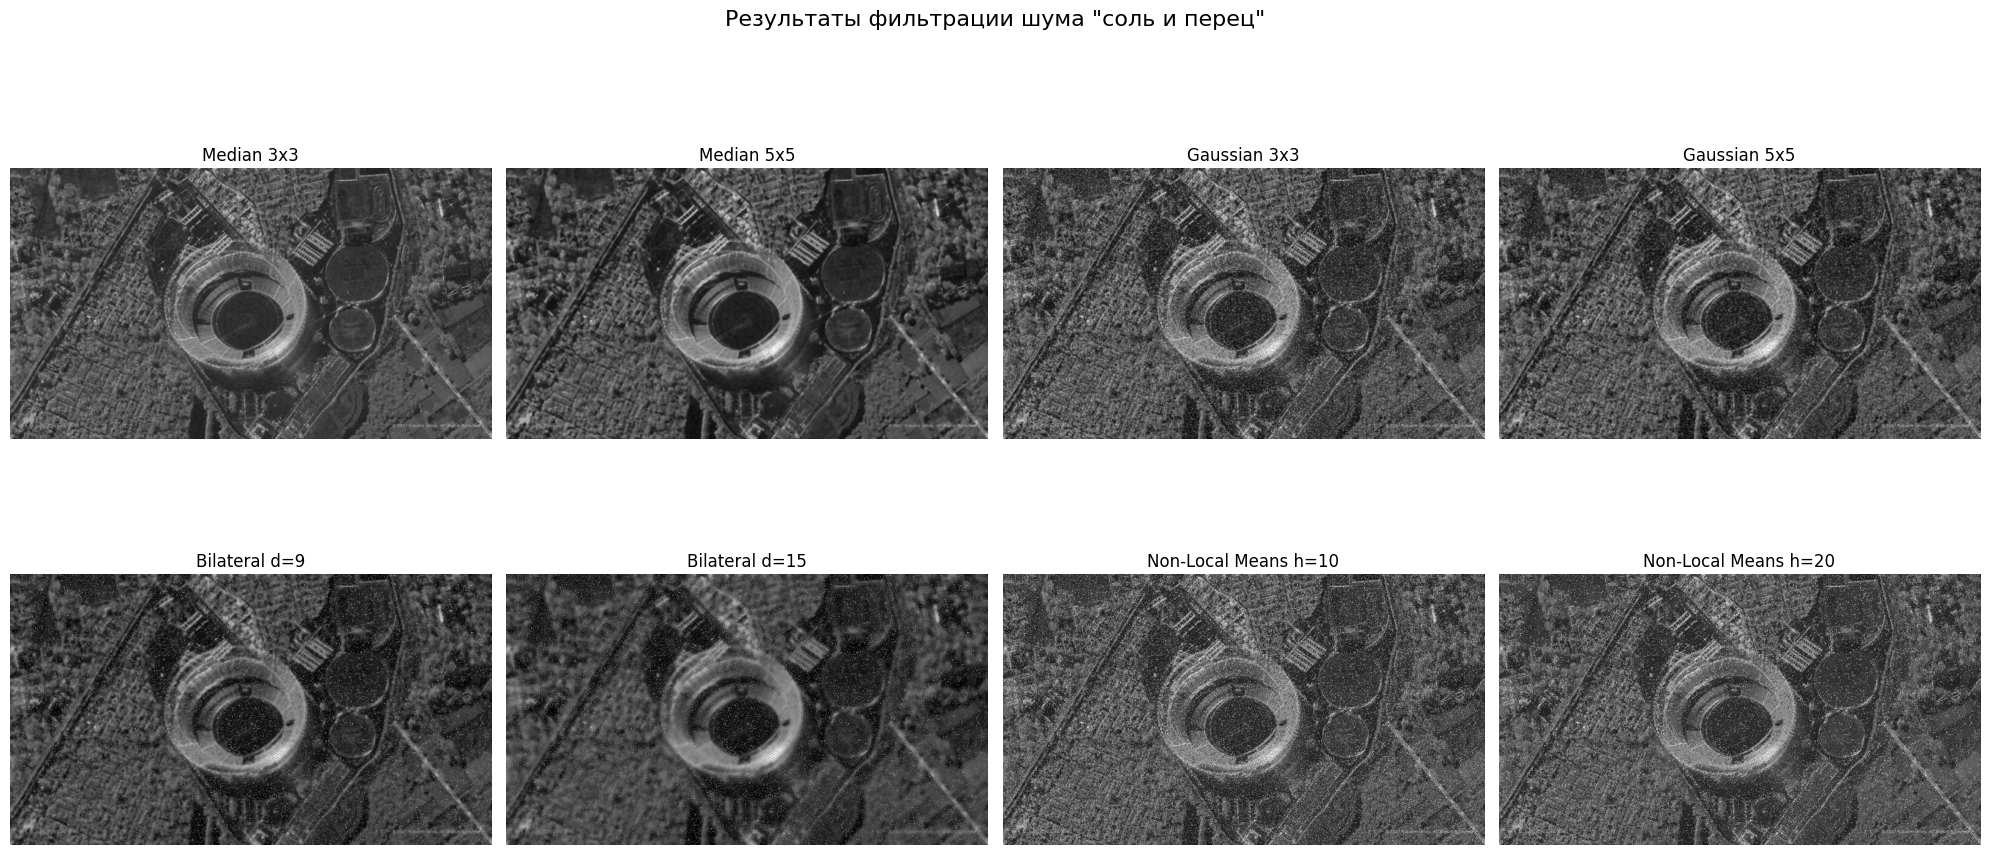

Результаты фильтрации (MSE, SSIM, PSNR):

Шум Гаусса:
Фильтр			MSE		SSIM		PSNR
Median 3x3          	15571.27		0.0533		27.57
Median 5x5          	15223.05		0.0544		27.54
Gaussian 3x3        	10276.42		0.1726		27.85
Gaussian 5x5        	9876.13		0.2110		27.85
Bilateral d=9       	13739.03		0.0693		27.62
Bilateral d=15      	13697.77		0.0661		27.62
Non-Local Means h=10	15827.16		0.0547		28.11
Non-Local Means h=20	15825.92		0.0549		28.11

Шум 'Соль и перец':
Фильтр			MSE		SSIM		PSNR
Median 3x3          	107.93		0.8023		31.58
Median 5x5          	199.21		0.6285		30.31
Gaussian 3x3        	362.02		0.5519		29.71
Gaussian 5x5        	287.71		0.5780		29.44
Bilateral d=9       	770.59		0.3278		29.73
Bilateral d=15      	755.49		0.2701		29.36
Non-Local Means h=10	1875.59		0.2993		37.54
Non-Local Means h=20	1644.71		0.3161		34.57

Лучший фильтр для шума Гаусса: Non-Local Means h=10
Лучший фильтр для шума 'Соль и перец': Non-Local Means h=10


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, mean_squared_error

def load_image(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def add_gaussian_noise(image, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    return cv2.add(image, noise)

def add_salt_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    noisy_image = np.copy(image)
    # Соль (белые точки)
    salt_mask = np.random.random(image.shape) < salt_prob
    noisy_image[salt_mask] = 255
    # Перец (черные точки)
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy_image[pepper_mask] = 0
    return noisy_image

def apply_filters(noisy_images):
    filters = {
        'Median 3x3': {
            'gn': cv2.medianBlur(noisy_images['gn'], 3),
            'sp': cv2.medianBlur(noisy_images['sp'], 3)
        },
        'Median 5x5': {
            'gn': cv2.medianBlur(noisy_images['gn'], 5),
            'sp': cv2.medianBlur(noisy_images['sp'], 5)
        },
        'Gaussian 3x3': {
            'gn': cv2.GaussianBlur(noisy_images['gn'], (3, 3), 0),
            'sp': cv2.GaussianBlur(noisy_images['sp'], (3, 3), 0)
        },
        'Gaussian 5x5': {
            'gn': cv2.GaussianBlur(noisy_images['gn'], (5, 5), 0),
            'sp': cv2.GaussianBlur(noisy_images['sp'], (5, 5), 0)
        },
        'Bilateral d=9': {
            'gn': cv2.bilateralFilter(noisy_images['gn'], 9, 75, 75),
            'sp': cv2.bilateralFilter(noisy_images['sp'], 9, 75, 75)
        },
        'Bilateral d=15': {
            'gn': cv2.bilateralFilter(noisy_images['gn'], 15, 75, 75),
            'sp': cv2.bilateralFilter(noisy_images['sp'], 15, 75, 75)
        },
        'Non-Local Means h=10': {
            'gn': cv2.fastNlMeansDenoising(noisy_images['gn'], None, 10, 7, 21),
            'sp': cv2.fastNlMeansDenoising(noisy_images['sp'], None, 10, 7, 21)
        },
        'Non-Local Means h=20': {
            'gn': cv2.fastNlMeansDenoising(noisy_images['gn'], None, 20, 7, 21),
            'sp': cv2.fastNlMeansDenoising(noisy_images['sp'], None, 20, 7, 21)
        }
    }
    return filters

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_metrics(original, filtered):
    mse = mean_squared_error(original, filtered)
    ssim_val = ssim(original, filtered)
    psnr_val = calculate_psnr(original, filtered)
    return mse, ssim_val, psnr_val

def evaluate_filters(original, filters):
    """Оценка эффективности фильтров"""
    results = {}
    for filter_name, filtered_imgs in filters.items():
        results[filter_name] = {
            'Gaussian': calculate_metrics(original, filtered_imgs['gn']),
            'SaltPepper': calculate_metrics(original, filtered_imgs['sp'])
        }
    return results

def plot_original_and_noisy(original, noisy_gn, noisy_sp):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Оригинальное изображение')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_gn, cmap='gray')
    plt.title('Шум Гаусса')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(noisy_sp, cmap='gray')
    plt.title('Шум "Соль и перец"')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_filtered_results(filters, noise_type, title):
    plt.figure(figsize=(20, 10))
    plt.suptitle(title, fontsize=16)
    
    for i, (filter_name, filtered_imgs) in enumerate(filters.items()):
        plt.subplot(2, 4, i + 1)
        plt.imshow(filtered_imgs[noise_type], cmap='gray')
        plt.title(filter_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def print_results(results):
    print("Результаты фильтрации (MSE, SSIM, PSNR):")
    print("\nШум Гаусса:")
    print("Фильтр\t\t\tMSE\t\tSSIM\t\tPSNR")
    for filter_name, metrics in results.items():
        mse, ssim_val, psnr_val = metrics['Gaussian']
        print(f"{filter_name:20}\t{mse:.2f}\t\t{ssim_val:.4f}\t\t{psnr_val:.2f}")

    print("\nШум 'Соль и перец':")
    print("Фильтр\t\t\tMSE\t\tSSIM\t\tPSNR")
    for filter_name, metrics in results.items():
        mse, ssim_val, psnr_val = metrics['SaltPepper']
        print(f"{filter_name:20}\t{mse:.2f}\t\t{ssim_val:.4f}\t\t{psnr_val:.2f}")

def find_best_filters(results):
    best_gn_filter = max(results, key=lambda k: results[k]['Gaussian'][2])
    best_sp_filter = max(results, key=lambda k: results[k]['SaltPepper'][2])
    
    print(f"\nЛучший фильтр для шума Гаусса: {best_gn_filter}")
    print(f"Лучший фильтр для шума 'Соль и перец': {best_sp_filter}")
    
    return best_gn_filter, best_sp_filter

def main():
    # загрузка изображения
    img = load_image('sar_1.jpg')
    
    # добавление шумов
    img_gn = add_gaussian_noise(img)
    img_sp = add_salt_pepper_noise(img)
    
    # визуализация оригинального и зашумленных изображений
    plot_original_and_noisy(img, img_gn, img_sp)
    
    # применение фильтров
    noisy_images = {'gn': img_gn, 'sp': img_sp}
    filters = apply_filters(noisy_images)
    
    # оценка эффективности фильтров
    results = evaluate_filters(img, filters)
    
    # визуализация результатов фильтрации
    plot_filtered_results(filters, 'gn', 'Результаты фильтрации гауссова шума')
    plot_filtered_results(filters, 'sp', 'Результаты фильтрации шума "соль и перец"')
    
    # вывод результатов
    print_results(results)
    
    # определение лучших фильтров
    best_gn_filter, best_sp_filter = find_best_filters(results)

if __name__ == "__main__":
    main()